In [172]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


In [173]:
df = pd.read_csv('data/space-missions-v3.csv')
print(df.head())
# Loaded here: https://www.kaggle.com/code/carlosmunozkampff/notebook831c35ceb1 and digested to this data:
# Data
data_yearly = {
    'Year': [1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'Number of Missions': [3, 28, 20, 39, 52, 82, 41, 60, 87, 101, 106, 103, 103, 107, 119, 99, 103, 98, 113, 113, 114, 97, 49, 55, 71, 67, 66, 69, 74, 62, 56, 59, 52, 80, 59, 62, 61, 64, 61, 60, 70, 68, 57, 57, 43, 49, 52, 40, 37, 49, 50, 48, 50, 37, 42, 38, 46, 53, 52, 90, 92, 117, 109, 119, 157, 93]
}

     Company                                   Location       Date      Time  \
0  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  10/4/1957  19:28:00   
1  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  11/3/1957   2:30:00   
2    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  12/6/1957  16:44:00   
3       AMBA   LC-26A, Cape Canaveral AFS, Florida, USA   2/1/1958   3:48:00   
4    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA   2/5/1958   7:33:00   

           Rocket         Mission RocketStatus Price MissionStatus  
0  Sputnik 8K71PS       Sputnik-1      Retired   NaN       Success  
1  Sputnik 8K71PS       Sputnik-2      Retired   NaN       Success  
2        Vanguard    Vanguard TV3      Retired   NaN       Failure  
3          Juno I      Explorer 1      Retired   NaN       Success  
4        Vanguard  Vanguard TV3BU      Retired   NaN       Failure  


In [174]:

# Create DataFrame
missions_per_year = pd.DataFrame(data_yearly)

# Convert 'Year' to datetime and set as index
missions_per_year['datetime'] = pd.to_datetime(missions_per_year['Year'], format='%Y')
missions_per_year = missions_per_year.drop('Year', axis=1).set_index('datetime')

# Display the updated DataFrame
print(missions_per_year)


            Number of Missions
datetime                      
1957-01-01                   3
1958-01-01                  28
1959-01-01                  20
1960-01-01                  39
1961-01-01                  52
...                        ...
2018-01-01                 117
2019-01-01                 109
2020-01-01                 119
2021-01-01                 157
2022-01-01                  93

[66 rows x 1 columns]


In [175]:
missions_per_year.head()

,Number of Missions
datetime,
1957-01-01,3
1958-01-01,28
1959-01-01,20
1960-01-01,39
1961-01-01,52


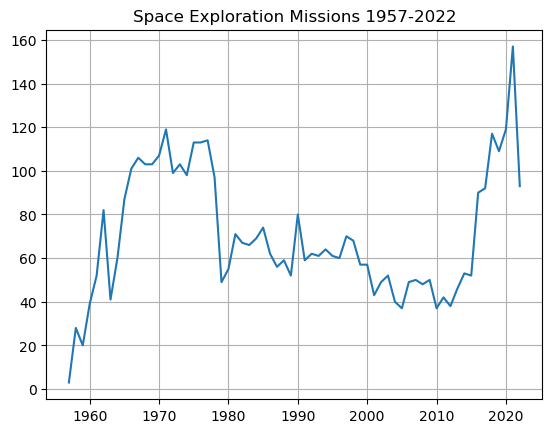

In [176]:
plt.plot(missions_per_year)
plt.title('Space Exploration Missions 1957-2022')
plt.grid();

In [177]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year and quarter from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Group by year and quarter and count the number of launches
launch_counts = df.groupby(['Year', 'Quarter']).size().reset_index(name='LaunchCount')

# Create a new DataFrame with the results
launch_counts_df = pd.DataFrame(launch_counts)

# Create a string representing the start of each quarter
launch_counts_df['QuarterStart'] = launch_counts_df['Year'].astype(str) + 'Q' + launch_counts_df['Quarter'].astype(str)

# Convert this string to a datetime object with a specified format
launch_counts_df['Datetime'] = pd.to_datetime(launch_counts_df['QuarterStart'].apply(lambda x: f"{x[:4]}-{int(x[5])*3-2:02d}-01"))

# Set the datetime column as the index
launch_counts_df.set_index('Datetime', inplace=True)

# Drop the Year, Quarter, and QuarterStart columns as they are now redundant
launch_counts_df.drop(columns=['Year', 'Quarter', 'QuarterStart'], inplace=True)

# Display the new DataFrame
print(launch_counts_df.head())

            LaunchCount
Datetime               
1957-10-01            3
1958-01-01            5
1958-04-01            5
1958-07-01           11
1958-10-01            7


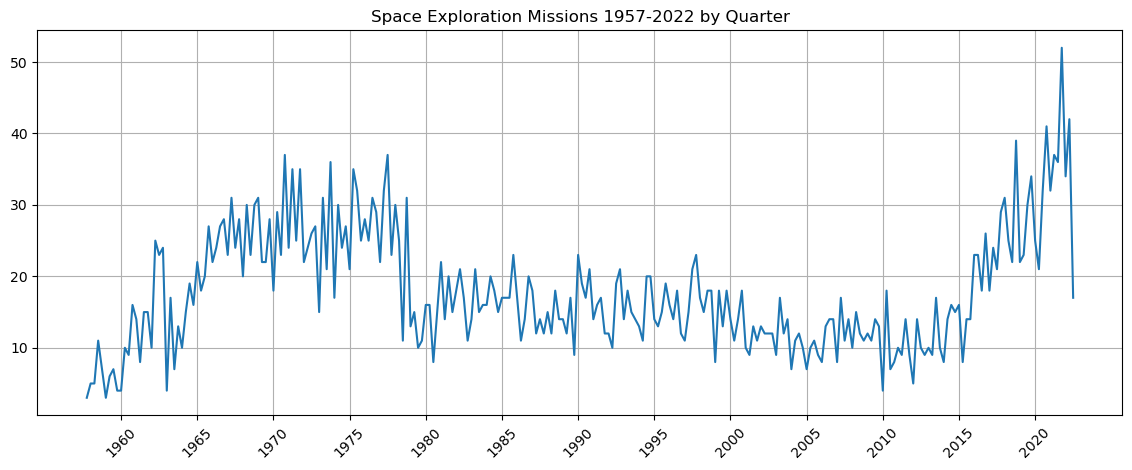

In [178]:
# Create a figure with the specified size
plt.figure(figsize=(14, 5))

# Plot the data
plt.plot(launch_counts_df['LaunchCount'])

# Set the title and grid
plt.title('Space Exploration Missions 1957-2022 by Quarter')
plt.grid()

# Set the x-axis ticks to display every 5 years
years = launch_counts_df.index.year.unique()
five_years = years[years % 5 == 0]
plt.xticks([pd.Timestamp(str(year)) for year in five_years], five_years)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Split historical and future data

In [179]:
y_hist = launch_counts_df.loc['2010':'2019','LaunchCount']
y_future = launch_counts_df.loc['2019':'2022','LaunchCount']

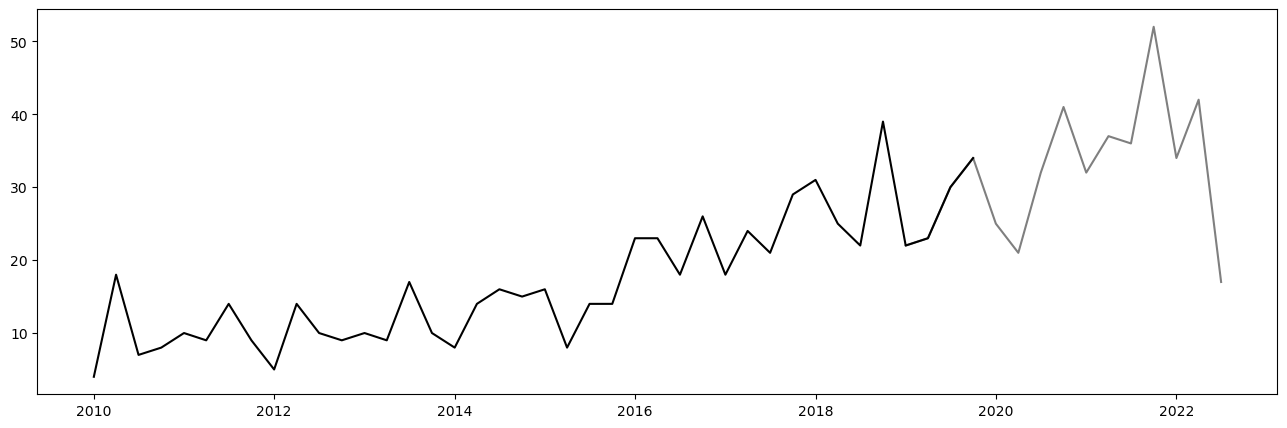

In [180]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)

# Extract the trend


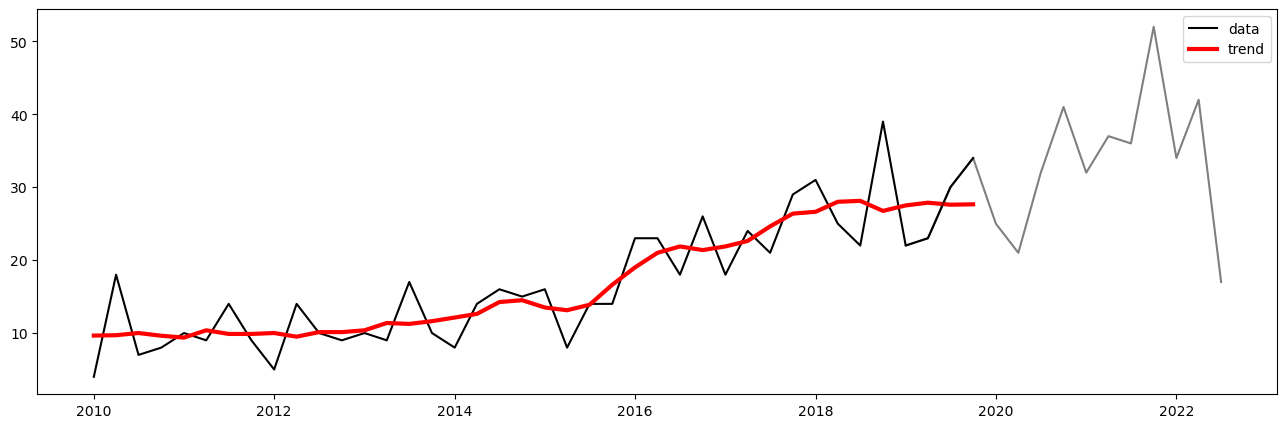

In [181]:
period = 4

filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

trend = convolution_filter(y_hist, filt)
trend = _extrapolate_trend(trend, period + 1)

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_future,'k',alpha=0.5)
plt.legend()

# Detrended data

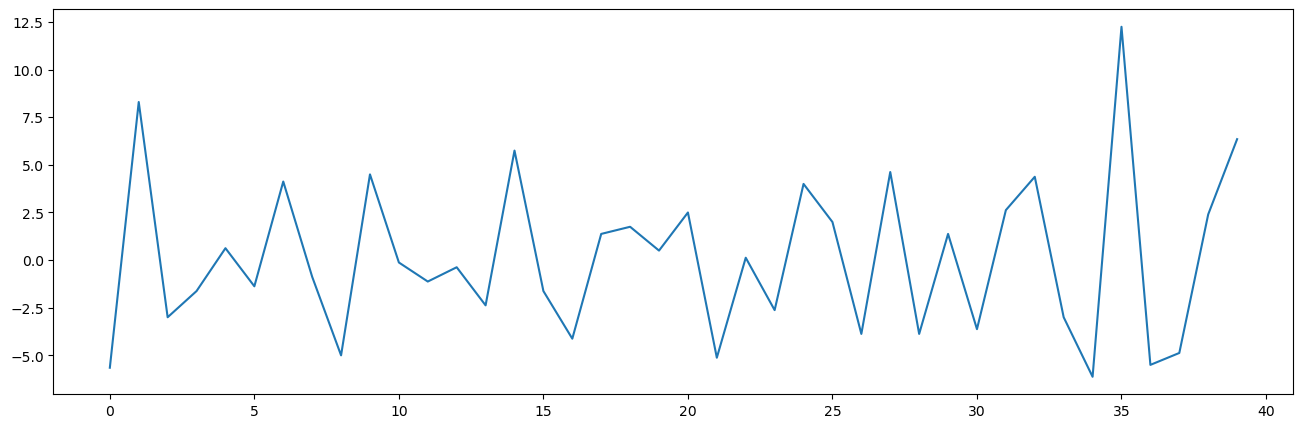

In [182]:
detrended = y_hist - trend
detrended = detrended.to_numpy()

plt.figure(figsize=(16,5))
plt.plot(detrended)

# Split the historical data into seasons

In [183]:
lows_index = [0,2,8,13,16,21,26,30,34,36]
lows = y_hist.index[lows_index]
lows

DatetimeIndex(['2010-01-01', '2010-07-01', '2012-01-01', '2013-04-01',
               '2014-01-01', '2015-04-01', '2016-07-01', '2017-07-01',
               '2018-07-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

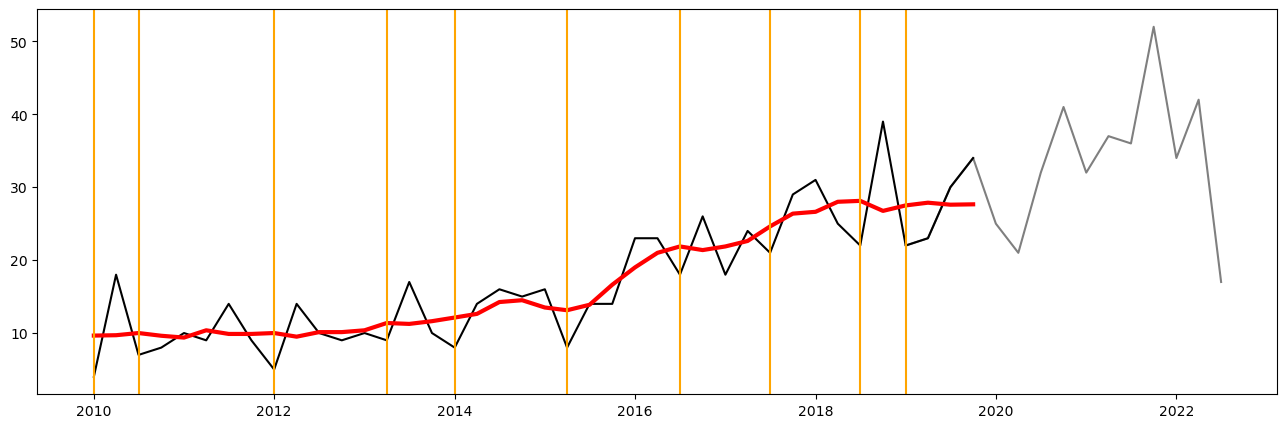

In [184]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

# Divide the detrended data into seasons

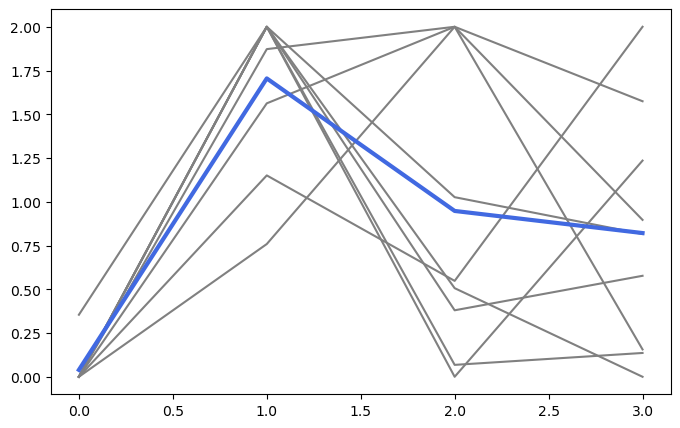

In [185]:
period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows)-1    
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

In [186]:
# Extract the quarter from the Datetime index
launch_counts_df['Quarter'] = launch_counts_df.index.quarter

# Filter the DataFrame for the fourth quarter
q4_launches_df = launch_counts_df.query('Quarter == 4')

# Drop the Quarter column as it's no longer needed
q4_launches_df.drop(columns=['Quarter'], inplace=True)

# Display the filtered DataFrame
print(q4_launches_df)

            LaunchCount
Datetime               
1957-10-01            3
1958-10-01            7
1959-10-01            4
1960-10-01           16
1961-10-01           15
...                 ...
2017-10-01           29
2018-10-01           39
2019-10-01           34
2020-10-01           41
2021-10-01           52

[65 rows x 1 columns]


/tmp/ipykernel_863/1613640147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q4_launches_df.drop(columns=['Quarter'], inplace=True)


# Remove outliers
We'll remove Quarter 37, 38, 36 (Quarters 2, 3, 4 of 2018) since that appears to be an outlier.

(37,)
Skipping segment 8 due to length mismatch: expected 4, got 3


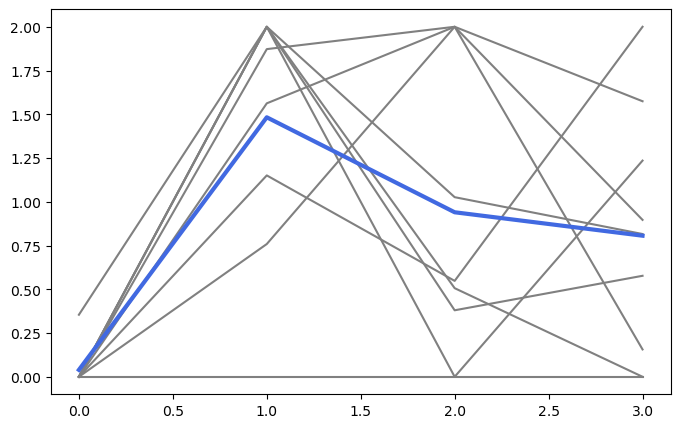

In [187]:
# Remove the last 3 quarters from the detrended data
detrended_no_outliers = detrended[:-3]
print(detrended_no_outliers.shape)  # Should be 37

# Recalculate the seasonal components if necessary
lows_index = [0,2,8,13,16,21,26,30,34,36]
lows = y_hist.index[lows_index]

period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows) - 1    
seasonals = np.empty((period, num_seasons))

for p in range(num_seasons):
    start_idx = lows_index[p]
    end_idx = start_idx + period
    s = detrended_no_outliers[start_idx:end_idx]
    
    # Check if the length of s matches the period
    if len(s) != period:
        print(f"Skipping segment {p} due to length mismatch: expected {period}, got {len(s)}")
        continue
    
    s = 2 * (s - np.min(s)) / (np.max(s) - np.min(s))
    seasonals[:, p] = s

mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8, 5))
for p in range(num_seasons):
    plt.plot(seasonals[:, p], color=0.5 * np.ones(3))
plt.plot(mean_seasonals, color='royalblue', linewidth=3)
plt.show()


In [188]:
# Initialize the seasonal series with float dtype

## THIS HAS ISSUE


##############################
seasonal = pd.Series(index=y_hist.index, data=0.0)

for low in lows_index:
    if low + period <= len(seasonal):
        seasonal[low:low + period] = mean_seasonals
    else:
        remaining_length = len(seasonal) - low
        seasonal[low:] = mean_seasonals[:remaining_length]

# Normalize the seasonal series
seasonal = seasonal / np.max(seasonal)

# Remove the last element from the seasonal series
seasonal = seasonal[:-1]

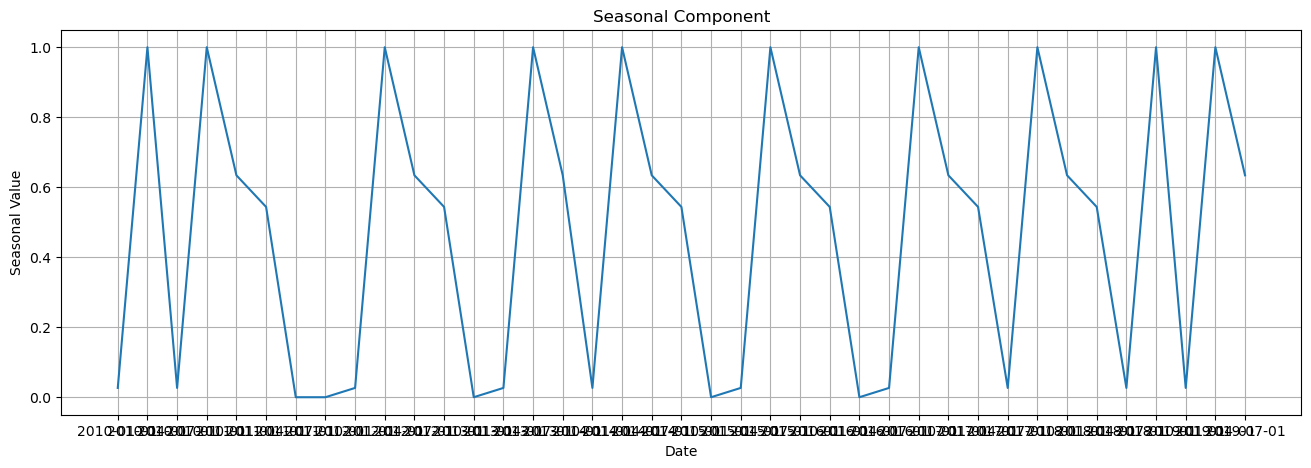

In [189]:
import sys
# sys.exit("Stopping the code here")

### THIS HAS ISSUE... 


###############################
# Ensure the index of seasonal is in string format if it's not already
if not isinstance(seasonal.index[0], str):
    seasonal.index = seasonal.index.astype(str)

# Plot the seasonal series
plt.figure(figsize=(16, 5))
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal Value')
plt.grid(True)
plt.show()



# DIFFERENT APPROACH USING SEASONAL DECOMPOSE LIBRARY


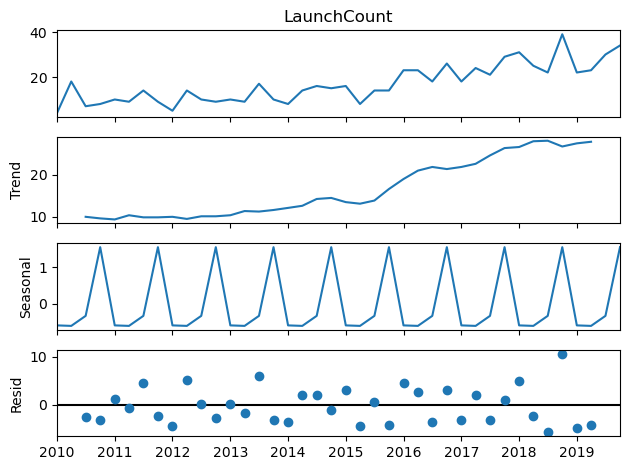

In [190]:
# Perform seasonal decomposition
result = seasonal_decompose(y_hist, model='additive', period=4)

# Plot the decomposed components
result.plot()
plt.show()

In [191]:
#instantiate
stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"})
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(y_future))

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


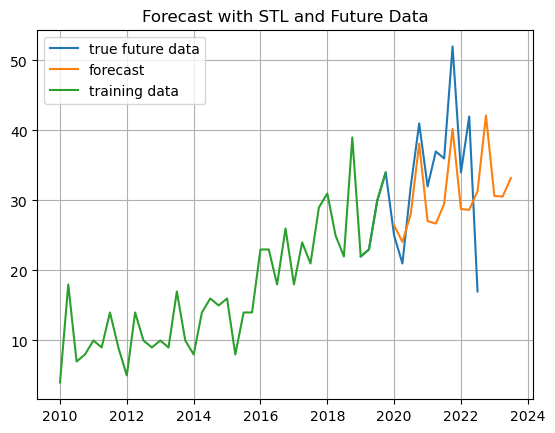

In [192]:
plt.plot(y_future, label = 'true future data')
plt.plot(forecast, label = 'forecast')
plt.plot(y_hist['1993':], label = 'training data')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();

In [193]:
pred_error = y_future - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt(np.square(pred_error).mean())


# Answer check
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 7.070488640929349
RMSE: 8.297668783728618


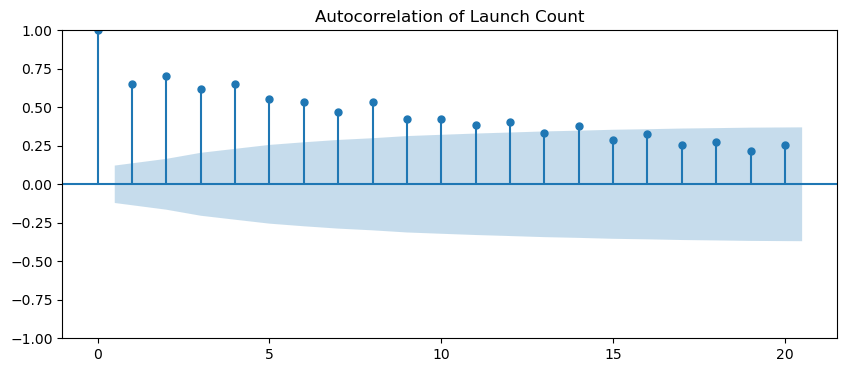

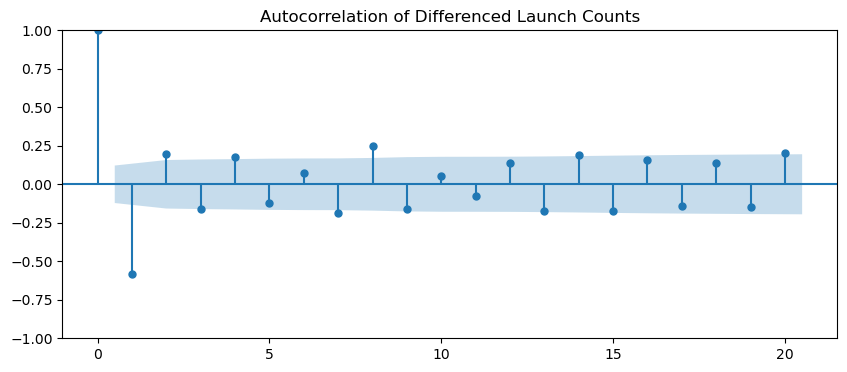

In [198]:
# Plot the autocorrelation of the differenced data
fig, ax = plt.subplots(figsize=[10, 4])
plot_acf(launch_counts_df['LaunchCount'], lags=20, ax=ax)
ax.set_title('Autocorrelation of Launch Count')
plt.show()

# Difference the 'Adj Close' column to make it stationary
launch_counts_df['LaunchCount_diff'] = launch_counts_df['LaunchCount'].diff()

# Drop the first row with NaN value resulting from differencing
lc_diff = launch_counts_df.dropna()

# Compute the autocorrelation of the differenced data
tsla_acf = acf(lc_diff['LaunchCount_diff'], nlags=20, fft=True)

# Plot the autocorrelation of the differenced data
fig, ax = plt.subplots(figsize=[10, 4])
plot_acf(lc_diff['LaunchCount_diff'], lags=20, ax=ax)
ax.set_title('Autocorrelation of Differenced Launch Counts')
plt.show()